<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
import string
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
MAX_HIGHT = 128
MAX_WIDTH = 256
IMG_FOLDER = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
LABELS_JSON = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json'
#Dont use @ in the alphabet. if you need you need to change the fillup char
ALPHABETS = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
ALPHABETS = string.digits + string.ascii_letters + '!?.-() '
max_str_len = 24 # max length of input labels
num_of_characters = len(ALPHABETS) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels
BATCH_SIZE = 64


In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [3]:
### Converting Chars to nums is better for ML
def label_to_num(label):
    #fills up the label with @
    label = label.ljust(max_str_len, '@')
    label_num = []
    for ch in label:
      label_num.append(ALPHABETS.find(ch) if ALPHABETS.find(ch)!=-1 else -1)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=ALPHABETS[ch]
    return ret


(26, 70)


"Type img       :<class 'numpy.ndarray'>"

"Type final_img :<class 'numpy.ndarray'>"

'Shape img      :(26, 70)'

'Shape final img:(128, 256)'

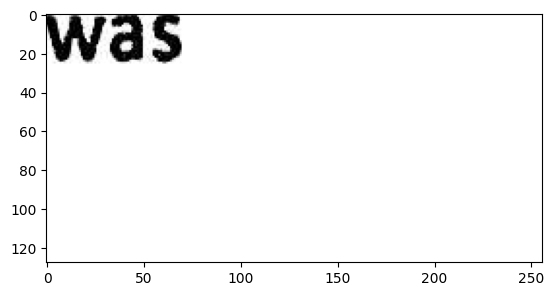

In [169]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images
def resize_to_desired_shape(img):
    (h, w) = img.shape


    #Scale all Images down that image width is max_width
    scaleFactor = MAX_WIDTH / w
    if scaleFactor < 1:
      img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
      (h, w) = img.shape

    #creates blank white image with size max_hight x max_width
    final_img = np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # if hight is still greater than max_hight, scale only hight down to max_hight
    if h > MAX_HIGHT:
       img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))


    # fills the blank image with resized imput image
    final_img[:h, :w] = img
    display("Type img       :" +  str(type(img)))
    display("Type final_img :" +  str(type(final_img)))
    display("Shape img      :" +  str(img.shape))
    display("Shape final img:" +  str(final_img.shape))
    return final_img

imgPath = os.path.join(IMG_FOLDER, "11.png")
image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(resize_to_desired_shape(image),cmap='gray')

In [5]:
def load_image_and_resize(imgPath):
  entry = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
  print("loaded:  " + imgPath)
  return resize_to_desired_shape(entry)

In [6]:
# Add the total path to image name
def make_total_path(imgName):
  return IMG_FOLDER + imgName

In [7]:
def rotateImage(Image):
  return cv2.rotate(Image, cv2.ROTATE_90_CLOCKWISE)

In [11]:
#Reading the json {Image_filename, "test on Image"}
with open(LABELS_JSON) as f:
    data = list(json.load(f).items())

#Reduced to just 500, change it to all for real training
keyVal = np.array(data[:100])
y_all = keyVal[:,1]
x_all_img_file_name = keyVal[:,0]
x_all_img_total_path = np.array([make_total_path(imgName) for imgName in x_all_img_file_name])

In [ ]:
#Reading all Images and put into a np array
images = []
with ThreadPoolExecutor() as executor:
    results = executor.map(lambda path: load_image_and_resize(path), x_all_img_total_path)
    for result in results:
        if result is not None:
            images.append(result)

x_all = np.array(images)

In [15]:
plt.imshow(x_all[0],cmap='gray')

NameError: name 'x_all' is not defined

In [ ]:
#Convert Char Labels to num Labels
y_all_numbers = np.array([label_to_num(xi) for xi in y_all])

#rotate that x = Width and y = hight
#x_all_rotate = np.array([rotateImage(xi) for xi in x_all])

#and reshape
x_train_rotate_reshaped = np.array(x_all_rotate).reshape(-1, MAX_WIDTH, MAX_HIGHT, 1)

In [19]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(ALPHABETS), num_oov_indices=0, mask_token=None
)

In [ ]:
y_all
list(x_all_img_total_path)

TypeError: Invalid shape (0,) for image data

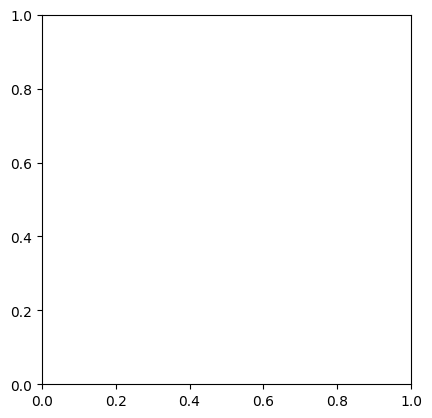

In [258]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images
def resize_to_desired_shape_for_tf(img):

    tf.print(img[15, 15])
    #img = img*255
    img = img.numpy()
    display("pixel an pos 1,1 :" + str(img[15, 15]))
    img = img[:,:,0]
    display("pixel an pos 1,1 :" + str(img[15, 15]))

    (h, w) = img.shape

    #Scale all Images down that image width is max_width
    scaleFactor = MAX_WIDTH / w
    if scaleFactor < 1:
      img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
      (h, w) = img.shape

    #creates blank white image with size max_hight x max_width
    final_img = np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # if hight is still greater than max_hight, scale only hight down to max_hight
    if h > MAX_HIGHT:
       img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))

    # fills the blank image with resized imput image
    final_img[:h, :w] = img
    final_img = final_img.reshape(MAX_HIGHT,MAX_WIDTH,1)
    final_img = tf.convert_to_tensor(())
    return final_img


plt.imshow(bla["image"])
plt.show()
_img = resize_to_desired_shape_for_tf(bla["image"])
plt.imshow(_img,cmap="gray")
print(_img.shape)


In [259]:
debugIMG = bla["image"]

In [260]:
debugIMG.shape[0]

0

In [257]:
def process_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # dimension to correspond to the width of the image.
    img = resize_to_desired_shape_for_tf(img)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    #img = tf.image.resize(img, [MAX_HIGHT, MAX_WIDTH])
    # 5. Transpose the image because we want the time

    #img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    #label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


bla = process_single_sample(x_all_img_total_path[1],y_all[1])
bla

[239]


'pixel an pos 1,1 :[239]'

'pixel an pos 1,1 :239'

{'image': <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>,
 'label': 'the'}

In [ ]:
x_all_img_total_path

In [238]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_all_img_total_path, y_all))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## Create the OCR Model

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [34,23,1], [batch]: [22,21,1] [Op:IteratorGetNext] name: 

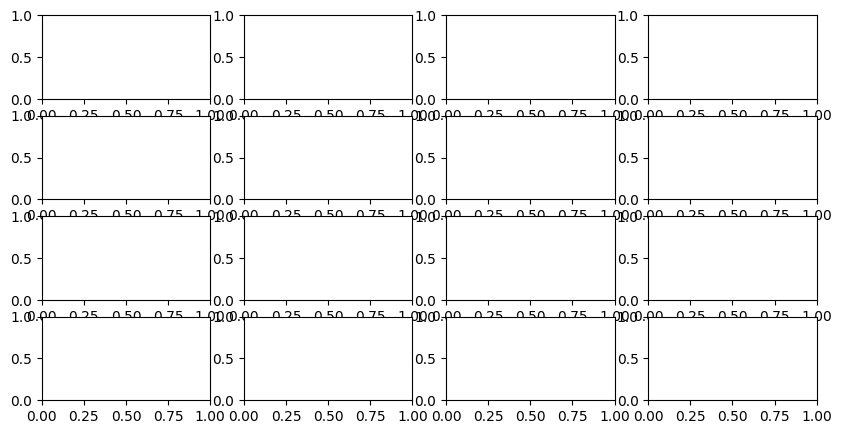

In [71]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title("label")
        ax[i // 4, i % 4].axis("off")
plt.show()

In [18]:
type(train_dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_rotate_reshaped, y_all_numbers, test_size=0.2, random_state=42)

# Print as sanity check
print(y_train[3])
num_to_label(y_train[3])

[28 25 14 12 18 10 21 29 34 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


'specialty'

In [ ]:
input_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
label_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
data_set = [x_train, y_train,input_length, label_length]
print(len(y_all_numbers))
print(x_train_rotate_reshaped[1].shape)

In [ ]:
x_train[0].shape

(256, 128, 1)

should


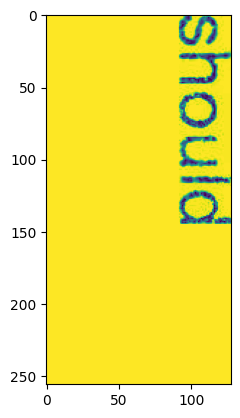

In [ ]:
print(num_to_label(y_all_numbers[455]))
plt.imshow(x_all_rotate[455])
plt.show()

#Building the Model

In [ ]:

# Evtl. Input umformatieren in einzeilig
input_data = Input(shape=(MAX_WIDTH, MAX_HIGHT, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 128, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 128, 32)      128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 256, 128, 32)      0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 64, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 64, 64)       18496     
                                                           

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
input_length

<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'input_length')>

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

In [ ]:
x_train.shape

(400, 256, 128, 1)

In [ ]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model_final.fit(data_set,
                 epochs=8, batch_size = 1,
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])


Epoch 1/8


ValueError: Target data is missing. Your model was compiled with loss={'ctc': <function <lambda> at 0x78b4f0ffe0e0>}, and therefore expects target data to be provided in `fit()`.